In [ ]:
import config #Local config file
import os
import csv
import sys

from datasets import load_dataset, load_from_disk
from transformers import LongformerTokenizerFast

from tqdm.auto import tqdm

import pandas as pd
import seaborn as sns
sns.set(style='darkgrid')

In [ ]:
def batch_tokenizer(batch):
    return tokenizer(batch["text"], padding='do_not_pad', truncation=False)

In [15]:
# Load the data from csv cache and tokenize without padding or truncation.
# Real data is padded and trimmed to model size in application. This just for data analysis.
data_files = os.path.join('../data/patentsview', 'patents_2019.csv')
dataset = load_dataset('csv', data_files=data_files, cache_dir=os.path.join('../data/patentsview', 'cache'))

tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096')
tokenized_data = dataset.map(batch_tokenizer, batched=True, remove_columns=['text'])

tokenized_data.save_to_disk(os.path.join('../data/patentsview', "tokenized/nopad_notrim_patents_2019_tokenized"))

In [ ]:
# Load the tokenized data for analysis
tokenized_data = load_from_disk(os.path.join('../data/patentsview', "tokenized/nopad_notrim_patents_2019_tokenized"))

In [14]:
progress_bar = tqdm(range(len(tokenized_data['train'])))

  1%|          | 2598/310000 [00:53<1:45:25, 48.59it/s]


In [15]:
# Create and save a dataframe only consist of token length and class value for fast and easy analysis.
# Indexing is still the same with the original data if a comparison is required.

df = pd.DataFrame(columns=['num_tokens','label'])
for i, patent in enumerate(tokenized_data['train']):
    df.loc[i] = [len(patent['input_ids']), config.id2label[patent['label']]]
    progress_bar.update(1)

df.to_csv("../data/patentsview/meta/patents_2019_num_tokens_and_label.csv", index=False)
df

100%|█████████▉| 309998/310000 [1:45:43<00:00, 31.42it/s]  

,num_tokens,label
0,579,A
1,8170,G
2,2184,A
3,3068,A
4,14379,A
...,...,...
309995,18198,A
309996,3069,G
309997,7044,G
309998,31109,G


In [10]:
# Percent of tokens that are not exceeding max length of longformer model.

df[df['num_tokens'] < 4096].shape[0] / df.shape[0]

0.22326129032258066

In [3]:
# Load the data to work on.

df= pd.read_csv("../data/patentsview/meta/patents_2019_num_tokens_and_label.csv")
df

,num_tokens,label
0,579,A
1,8170,G
2,2184,A
3,3068,A
4,14379,A
...,...,...
309995,18198,A
309996,3069,G
309997,7044,G
309998,31109,G


In [46]:
# Quick first check. We see a very high std and max. Other info seems reasonable. 34 token min is suspicious.

print(df.describe())

          num_tokens
count  310000.000000
mean    11487.254961
std     17196.713500
min        34.000000
25%      4425.750000
50%      7654.000000
75%     12911.000000
max    886819.000000


In [17]:
# Another quick look

df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310000 entries, 0 to 309999
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   num_tokens  310000 non-null  int64 
 1   label       310000 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.7+ MB


100%|██████████| 310000/310000 [1:45:57<00:00, 31.42it/s]

<AxesSubplot:xlabel='num_tokens', ylabel='Count'>

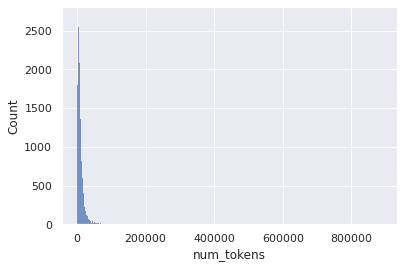

In [5]:
# Token length distribution. Looks too unbanaced. There must be outliers.

sns.histplot(data=df, x='num_tokens', binwidth=100, kde=True)

<AxesSubplot:xlabel='num_tokens', ylabel='Count'>

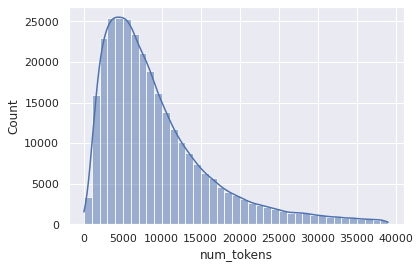

In [19]:
# Token length distribution of first shortest 300.000 patent. (longest 10.000 patent trimmed)

# A well defined outlier clean method should be used in the future.
# A more sensible chart we see.
# For the min token length 34, it is not a problem for now because it is not a dominant force statistically.

sns.histplot(data=df.sort_values(by='num_tokens')[:300000], x='num_tokens', binwidth=1000, kde=True)

In [5]:
# Quick look to the shortest 300.000 data. We see a more reasonable max and std values.

df.sort_values(by='num_tokens')[:300000].describe()

,num_tokens
count,300000.000000
mean,9344.468727
std,7066.145166
min,34.000000
25%,4324.000000
50%,7414.000000
75%,12168.000000
max,39017.000000


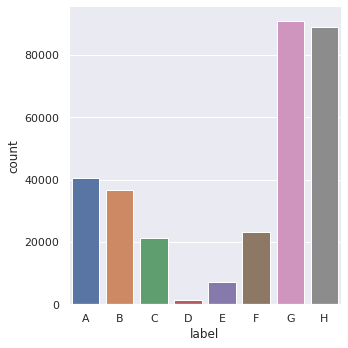

In [30]:
# Label count distribution. How many patents are there for each label.

# D is too few.
# G and H is dominating.

sns.catplot(data=df, x="label", kind="count", order=config.labels_list)

In [ ]:
# Lets remember the meanings of the labels for more context.

# Domination of G and H makes more sense now.
# It must be a tough year for texlie industry.

# A - Human Necessities
# B - Performing Operations; Transporting
# C - Chemistry; Metallurgy
# D - Textiles; Paper
# E - Fixed Constructions
# F - Mechanical Engineering; Lighting; Heating; Weapons; Blasting
# G - Physics
# H - Electricity

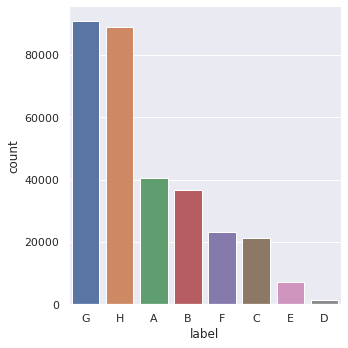

In [7]:
# Let's see the sorted version for fun.

sns.catplot(data=df, x="label", kind="count", order=df['label'].value_counts().index)

In [9]:
# Mean token lengths of patents grouped by labels.

mean_list = []
for label in config.labels_list:
    mean = round(df[df['label']== label]['num_tokens'].mean()) 
    mean_list.append(mean)
    print("Mean token length of label {} is {}".format(label, mean))

Mean token length of label A is 14558
Mean token length of label B is 7624
Mean token length of label C is 23219
Mean token length of label D is 8826
Mean token length of label E is 6627
Mean token length of label F is 6509
Mean token length of label G is 11318
Mean token length of label H is 10806


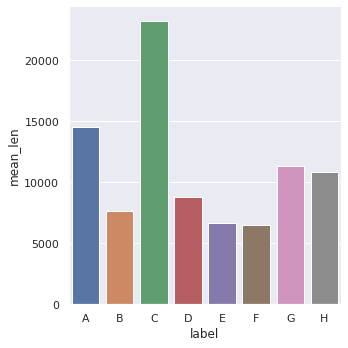

In [10]:
# The table of mean token lengths of patents grouped by labels.

# C contains the outliers, apart from that, seem like lengths of the patents distributed in a balanced way along the labels.

mean_table = pd.DataFrame(data={"label":config.labels_list, "mean_len":mean_list})
sns.catplot(data=mean_table, x='label', y='mean_len', kind='bar')

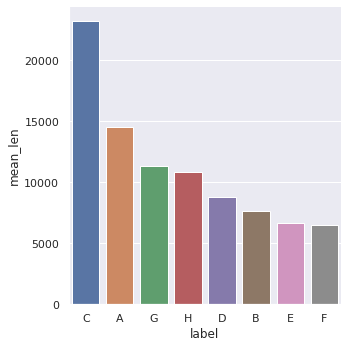

In [20]:
# And the sorted

mean_table.sort_values(by='mean_len', inplace=True, ascending=False)
sns.catplot(data=mean_table, x='label', y='mean_len', kind='bar')

In [45]:
# Fianlly see the describe values for each label separately.
for label in config.labels_list:
    print("Label: {}".format(label))
    print(df[df['label']== label].describe())
    print("-----------------------------------")

Label: A
          num_tokens
count   40380.000000
mean    14557.523081
std     24551.538353
min        34.000000
25%      4076.000000
50%      7913.500000
75%     15852.750000
max    880936.000000
-----------------------------------
Label: B
          num_tokens
count   36610.000000
mean     7623.975389
std      8563.672966
min        54.000000
25%      3035.250000
50%      5369.500000
75%      9251.750000
max    320991.000000
-----------------------------------
Label: C
          num_tokens
count   21195.000000
mean    23218.574617
std     39272.973034
min        34.000000
25%      5864.000000
50%     11758.000000
75%     24312.500000
max    886819.000000
-----------------------------------
Label: D
          num_tokens
count    1406.000000
mean     8826.067568
std     11321.460105
min       246.000000
25%      3369.000000
50%      5893.000000
75%     10347.250000
max    148121.000000
-----------------------------------
Label: E
          num_tokens
count    7286.000000
mean     6626